# Import Data & Packages

In [1]:
import pandas as pd
import numpy as np
import datetime
from ast import literal_eval
import konlpy
from collections import Counter
import time
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
pd.__version__

'1.1.3'

In [3]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [3]:
df_whole=pd.read_json('amore_data_detected_bert.json')
df_whole['review_split_string']=df_whole['review_split'].copy()
df_whole['review_split']=df_whole['review_split_string'].apply(literal_eval)
print(df_whole.shape)

(50183, 50)


In [4]:
df_whole['name']=df_whole[['brand','big_category','prod_nm']].agg('#'.join, axis=1)
df_whole['name_sub']=df_whole[['brand','big_category']].agg('#'.join, axis=1)

In [5]:
df_whole.head(2)

,A용량,A민감성,A향기,A커버력,A지속력,A피부톤,A보습감,A향,A사용감,A발림성,...,트러블,표현력,품질,향기,효과,휴대성,mask,review_split_string,name,name_sub
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,"[True, False, False]","['바디워시 쓰고 반해서 핸드워시도 사게 됬어요', '바디워시와 같은향이라 그런지 ...",sulhwasoo#catE#핸드워시 백은향 300ml,sulhwasoo#catE
1,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,"[True, False, False]",['선물하기에 너무 좋아용 사실 내돈주고 사기엔 아깝구 선물 받은 좋은 아이템 ㅎㅎ...,sulhwasoo#catE#핸드워시 백은향 300ml,sulhwasoo#catE


# Functions

In [26]:
def S1_number_func(x):
    return(sum([len(x[i].split(' ')) for i in range(len(x))]))

def S1_duplicate_func(x):
    return(len(set(x))/len(x))
    
def NVA(x):    
    total_words=[]
    for i, document in enumerate(list(set(x))):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): 
            if word[1] in ['Noun', 'Verb', 'Adjective']: 
                clean_words.append(word[0])
        total_words.append(clean_words)
    result = []
    for x in total_words:
        result.extend(x)
    return result


def S1_diversity_func(NVA):  
    return(len(set(NVA))/len(NVA))
    


def s1_recency_func(x,date):
    return((date-x.date()).days)

def S1_recency_func(x,max_date,window):
    """
    max=50 ( 50,49,,...1 )
    ----------------------------------------
    50,49,48,47,46 .... (max-0)~(max-window+1)
    49,48,47,46,45 .... (max-1)~(max-window+0)
    48,47,46,45,44 .... (max-2)~(max-window-1)
    ...
    5,4,3,2,1 ...,,,,,,. (max-45)~(max-window-44)
    ----------------------------------------
    max-45가 window가 될 때 까지
    """
    lower = max_date
    upper = max_date-window+1
    lower_sign=(x<=lower)
    upper_sign=(x>=upper)
    sign=lower_sign*upper_sign
    return sign

def s1_recency_list_func(prod_nm):
    tmp=S1_recency[S1_recency['name']==prod_nm]
    MA_list=[]
    for i in date_range:
        window_count = len(tmp['recency'][tmp['recency'].apply((lambda x: S1_recency_func(x,max_date-i,recency_window)))>0])
        window_count_mean = window_count/recency_window
        MA_list.append(window_count_mean)
    return MA_list

# exCBS

## 날짜 범위 설정

- 점수 계산 날짜 : (x)일
- 점수 계산 대상 날짜 : (x-14)일~ (x)일

In [10]:
def get_current_Kdays(df,current_Y,current_M,current_D,K=14):
    eval_date = datetime.date(current_Y,current_M,current_D)
    df['recency']=df['date'].apply((lambda x: s1_recency_func(x,eval_date)))
    return df[df['recency']<K]

In [8]:
df = get_current_Kdays(df_whole,2021,7,31,K=14)
recent_idx=df.index

In [9]:
df.shape

(1036, 53)

## Impression & Variety 계산 준비

In [11]:
import torch

In [12]:
model = torch.load('checkpoint39.pt',map_location='cpu')

In [13]:
cat_task = {'cat1': 1, 'cat2': 2,'cat3': 3,'cat4': 4,'cat5': 5,'cat6': 6,'cat7': 7,'cat9': 8,'cat10': 9}
cols1 = ['용량','민감성','향기','커버력','지속력','피부톤',
         '보습감','향','사용감','발림성','세정력', # 10
         '촉촉함','유분기','발색감','제형']#,'보습력']
cols2= df.columns[25:48]
small_cat_indices = [[1, 10, 11],
                     [1, 6, 7],
                     [1, 8, 9],

                     [3, 4, 5],

                     [4, 5, 11, 12, 13, 14],

                     [4, 8, 13],
                     [4, 8, 13],

                     [2, 1, 0],
                     [2, 1, 0]]

In [14]:
temp_cols=["overall({})".format(i) for i in [-1,0,1]]+[c + '(-1)' for c in cols1]+[c + '(0)' for c in cols1]+[c + '(1)' for c in cols1]+['ATT_'+c for c in cols1]
S23=pd.DataFrame(index=recent_idx,columns=temp_cols)

In [13]:
from tqdm import tqdm

In [14]:
def softmax(x):
    return (torch.exp(x) / torch.exp(x).sum()).flatten()



def fill_s23(model, df, idicies):
    for ind in tqdm(idicies):
        
        review = torch.FloatTensor( df['embed_sents'][ind])
        num_sents = torch.tensor( len(review) )
        small_task= cat_task[ df['category'][ind] ]
        detect = df['mask'][ind]
        deteted_aspect= df.loc[ind,cols2][ df.loc[ind,cols2] == 1 ].index.values.tolist()
        deteted_aspect_ind = np.array( small_cat_indices[ small_task - 1 ] )[detect].tolist()
        deteted_aspect_target = np.array(cols1)[deteted_aspect_ind].tolist()
        model.eval()
        model.to('cpu')
        with torch.no_grad():
            out = model(review.unsqueeze(0), num_sents.unsqueeze(0))
        tg, ts, a1, a2, a3, a4, a5, a_g = out


        att_a = [a1[:3], a1[3:6],a1[6:], a2, a3, a4[:3], a4[4:], a5[:3], a5[3:]]

        overall_pred = dict( zip( ['5', '4', '1~3'], list(softmax(tg[small_task-1] )[[2,1,0]].data.numpy().round(3)) ) )

        S23.loc[ind,['overall(1)','overall(0)','overall(-1)']]=list(overall_pred.values())

        calibrated_imp = a_g[small_task-1].flatten()[[df['mask'][ind]]].numpy() / sum(a_g[small_task-1].flatten()[[df['mask'][ind]]].numpy() )
        aspect_imps = dict( zip( deteted_aspect_target, calibrated_imp) )

        for id_, (aspect_ind, aspect_name,aspect_imp) in enumerate(zip(deteted_aspect_ind, deteted_aspect_target,aspect_imps.values())):
        
            a_index = np.where( (np.array(small_cat_indices[small_task-1]) == aspect_ind))[0][0]
            aspect_pred = dict(zip(['1','0', '-1'], list(softmax(ts[small_task-1][a_index] )[[2,1,0]].data.numpy().round(3)) ))
            S23.loc[ind,aspect_name + '(1)']=aspect_pred['1']
            S23.loc[ind,aspect_name + '(0)']=aspect_pred['0']
            S23.loc[ind,aspect_name + '(-1)']=aspect_pred['-1']
            S23.loc[ind,'ATT_'+aspect_name]=aspect_imp



In [15]:
fill_s23(model, df,recent_idx)

100%|██████████████████████████████████████████████████████████████████████████████| 1036/1036 [00:56<00:00, 18.33it/s]


In [16]:
S23_copy = S23.copy()

In [17]:
eps=1
product_info=df[['name','big_category','brand','rating']]
product_sent_ratio=pd.crosstab(product_info.name, product_info.rating)
product_sent_ratio+=eps
product_sent_inv_ratio=product_sent_ratio.apply(lambda x : 1/x)
product_sent_inv_ratio=product_sent_inv_ratio.div(product_sent_inv_ratio.sum(axis=1), axis=0)
product_sent_inv_ratio.columns=['W_overall(-1)','W_overall(0)','W_overall(1)']
product_sent_inv_ratio.reset_index(inplace=True)

In [18]:
S23=pd.concat([S23,df['name']],axis=1)

##  (score 1) Impression

In [19]:
S2=S23[['overall(-1)','overall(0)','overall(1)','name']]

In [20]:
S2=pd.merge(S2,product_sent_inv_ratio,on='name',how='left')

In [21]:
S2['score(-1)']=(S2['overall(-1)']*S2['W_overall(-1)']).astype('float')
S2['score(0)']=(S2['overall(0)']*S2['W_overall(0)']).astype('float')
S2['score(1)']=(S2['overall(1)']*S2['W_overall(1)']).astype('float')

In [22]:
S2=S2[['name','score(-1)','score(0)','score(1)']]

In [23]:
S2=S2.groupby('name').mean()[['score(-1)','score(1)']]

In [24]:
S2=pd.DataFrame(S2['score(1)']-S2['score(-1)'],columns=['S2'])

In [25]:
score1 = S2

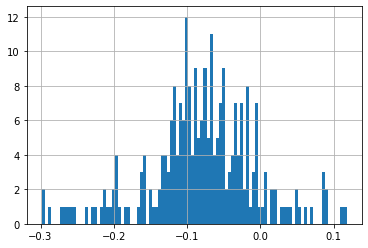

In [26]:
score1['S2'].hist(bins=100)

## (score 2) Variety

In [27]:
new_S3=S23[['name']]

W_temp=pd.merge(new_S3,product_sent_inv_ratio,on='name',how='left')

In [28]:
for col in cols1:
    X_temp=S23[S23.columns[S23.columns.str.contains(col)]]
    X_temp.iloc[:,:3]=X_temp.iloc[:,:3].mul(X_temp.iloc[:,3],axis=0)
    score_plus=np.array(X_temp[col+'(1)'])*np.array(W_temp['W_overall(1)'])
    score_minus=np.array(X_temp[col+'(-1)'])*np.array(W_temp['W_overall(-1)'])
    score_sum=score_plus-score_minus
    new_S3[col]=score_sum

C:\Users\LSH\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-28-52ab26ad04c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_temp.iloc[:,:3]=X_temp.iloc[:,:3].mul(X_temp.iloc[:,3],axis=0)
<ipython-input-28-52ab26ad04c8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [29]:
product_names=list(set(S23['name']))

In [30]:
S3=pd.DataFrame(index=S2.index,columns=cols1)

In [31]:
for prod_nm in product_names:
    prod_df=new_S3.groupby('name').get_group(prod_nm)    
    score_x=prod_df.mean()
    w=prod_df.shape[0]-prod_df.iloc[:,1:].isna().sum()
    score_w=w/w.sum()
    score_w=score_w.fillna(0)
    score=(score_x*score_w)
    S3.loc[prod_nm,:]=score

In [32]:
S3=pd.DataFrame(S3.sum(axis=1),columns=['S3'])

In [33]:
score2 = S3

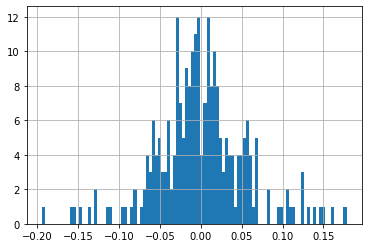

In [34]:
score2['S3'].hist(bins=100)

## (score 3) Association

속성 단어 사전

In [183]:
def get_coocmat(nva_topK):
    u = (pd.get_dummies(pd.DataFrame(nva_topK), prefix='', prefix_sep='')
       .groupby(level=0, axis=1)
       .sum())

    cooc_mat = u.T.dot(u)
    cooc_mat.values[(np.r_[:len(cooc_mat)], ) * 2] = 0
    return cooc_mat
    

In [184]:
def connectivity_from_cooc(coocurence_mat):
    cooc_mat = coocurence_mat.copy()
    print('shape of coocurrence matrix :',cooc_mat.shape)
    time1 = time.time()
    conn = cooc_mat.stack()
    conn=conn.rename_axis(('source','target')).reset_index(name='weight')
    G = nx.from_pandas_edgelist(conn,edge_attr=True)
    time2 = time.time()
    print('Constructing Graph took {} secs'.format(time2-time1))
    for u,v,data in G.edges(data=True):
        if 'weight' in data and data['weight']!=0:
            data['inverse']=1/data['weight']
        else:
            data['inverse']=1
    connectivity = nx.betweenness_centrality(G,normalized=False,weight='inverse',endpoints =True)
    time3 = time.time()
    print('Calculating Connectivity took {} secs'.format(time3-time2))
    return connectivity

In [65]:
aspect_list = ['가격','광택','구성','디자인','만족도','맛','성분','용기','트렌드','표현','품질','휴대']

In [53]:
nva=df['review_split'].apply(NVA)
#max_window = max([len(i) for i in nva]) -1
#nva_for_w2v=df_whole['review_split'].apply(NVA)
#model = Word2Vec(sentences=nva_for_w2v, size=100, window=max_window, min_count=5, workers=4, sg=0)
#model.wv.save_word2vec_format('aspect_dict_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("aspect_dict_w2v") # 모델 로드

211

In [86]:
aspect_dict = {}
for aspect in aspect_list:
    tmp=model.most_similar(aspect,topn=30)    
    aspect_dict[aspect]=[i[0] for i in tmp]

<ipython-input-86-989cf4e568bd>:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  tmp=model.most_similar(aspect,topn=30)


In [87]:
import itertools
import collections

In [177]:
def leave_only_aspect_and_product(nva,aspect_dict,node='brand'):
    #------------------------------------------------------------
    # [STEP 1] network의 node로 삼을 범위 
    # --- 후보 1) brand         ( ex. sulhwasoo )
    # --- 후보 2) brand+big     ( ex. sulhwasoo#catA )
    # --- 후보 3) brand+big+prd ( ex. sulhwasoo#catA#윤조&자음생 안티에이징 스페셜 리추얼세트(쇼핑백 포함) )
    #------------------------------------------------------------
    nva_replaced=[]
    nva_idx=nva.index
    
    assert node in ['brand','brand+big','brand+big+prd']
    if node=='brand':
        names=list(df['brand'])
    elif node=='brand+big':
        names=list(df['name_sub'])
    else:
        names=list(df['name'])
    
    #------------------------------------------------------------
    # [STEP 2] 중복되는 단어를 가진 속성 단어는, 양쪽에서 모두 제거하기
    # --- 근거 1) 어느쪽에 포함시켜야할지 manually 정해야
    # --- 근거 2) (2 이상의)여러 쪽에 속해 있다 = general한 속성이다
    #------------------------------------------------------------
    aspect_words_total=list(itertools.chain(*list(aspect_dict.values())))
    duplicate_words=[item for item, count in collections.Counter(aspect_words_total).items() if count > 1]
    for aspect in aspect_list:
        aspect_dict[aspect]=[word for word in aspect_dict[aspect] if word not in  duplicate_words]
    
    #------------------------------------------------------------
    # [STEP 3] aspect dictionary를 inverse 시키기
    #------------------------------------------------------------
    aspect_words_total_filtered=list(itertools.chain(*list(aspect_dict.values())))
    num_values_per_aspect=[len(list(aspect_dict.values())[i]) for i in range(len(aspect_dict.keys()))]
    keys_ = [num_values_per_aspect[i]*[list(aspect_dict.keys())[i]] for i in range(len(aspect_dict.keys()))]
    keys_=list(itertools.chain(*keys_))
    
    word2aspect_dict = dict(zip(aspect_words_total_filtered,keys_))
    
    #------------------------------------------------------------
    # [STEP 4] 리뷰 내에 "속성 단어"가 있을 경우, "속성"으로 대체하고, 없으면 제거
    #------------------------------------------------------------
    for i in range(len(nva)):
        nva_ = nva[nva_idx[i]]
        tmp=list(set([x.replace(x, word2aspect_dict[x]) for x in nva_ if x in aspect_words_total_filtered]))
        if len(tmp)>0:
            tmp.append(names[i])
            nva_replaced.append(tmp)
    return (nva_replaced)

In [190]:
review_filtered_brand=leave_only_aspect_and_product(nva,aspect_dict,'brand')
review_filtered_brand_big=leave_only_aspect_and_product(nva,aspect_dict,'brand+big')

In [191]:
cooc_mat_brand=get_coocmat(review_filtered_brand)
cooc_mat_brand_big=get_coocmat(review_filtered_brand_big)

In [192]:
connectivity_tmp_brand = connectivity_from_cooc(cooc_mat_brand)
connectivity_tmp_brand_big = connectivity_from_cooc(cooc_mat_brand_big)

shape of coocurrence matrix : (20, 20)
Constructing Graph took 0.0030090808868408203 secs
Calculating Connectivity took 0.004994869232177734 secs
shape of coocurrence matrix : (39, 39)
Constructing Graph took 0.006476879119873047 secs
Calculating Connectivity took 0.035527944564819336 secs


In [202]:
brand_included=list(set([i[-1] for i in review_filtered_brand]))
brand_big_included=list(set([i[-1] for i in review_filtered_brand_big]))

In [207]:
tmp=[]
for b in brand_included:
    tmp.append(connectivity_tmp_brand[b])
connectivity=tmp/max(np.array(tmp))

score3_brand=dict(zip(brand_included,connectivity))

In [212]:
tmp=[]
for b in brand_big_included:
    tmp.append(connectivity_tmp_brand_big[b])
connectivity=tmp/max(np.array(tmp))

score3_brand_big=dict(zip(brand_big_included,connectivity))

## (score 4) extension

In [15]:
df['s1_length']=df['review_split'].apply(len)
df['s1_number']=df['review_split'].apply(S1_number_func)
df['s1_duplicate']=df['review_split'].apply(S1_duplicate_func)

nva=df['review_split'].apply(NVA)
df['S1_diversity']=nva.apply(S1_diversity_func)
df['S1_number_discounted']=df['s1_number']*df['s1_duplicate']

<ipython-input-15-75b336e51c9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['s1_length']=df['review_split'].apply(len)
<ipython-input-15-75b336e51c9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['s1_number']=df['review_split'].apply(S1_number_func)
<ipython-input-15-75b336e51c9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [20]:
S1_cols=df.columns[df.columns.str.contains('S1')]
S1 = df.groupby('name')[S1_cols].mean()
S1_recency = df[['name','recency']]

In [38]:
recency_window=3
max_date=S1_recency['recency'].max()
date_range=np.arange(0,max_date-recency_window)

In [39]:
S1['s1_recency_list']=S1.reset_index()['name'].apply(s1_recency_list_func).values

In [70]:
def exp_decay_custom(alpha,list_):
    arr=np.array(list_)
    arr=arr/(arr.sum()+(1e-4))
    recency=[alpha]*len(arr)*arr
    recency=recency*[(1-alpha)**(len(recency)-i-1) for i in range(len(recency))]
    return sum(recency)

In [75]:
S1['S1_recency']=S1['s1_recency_list'].apply((lambda x: exp_decay_custom(0.5,x)))

In [77]:
S1.drop('s1_recency_list',axis=1,inplace=True)

In [78]:
S1

,S1_diversity,S1_number_discounted,S1_recency
name,,,
amore#catA#[리필] 모이스춰 플럼핑 듀이 미스트 100ml,0.886282,23.500000,0.172601
amore#catA#더 에센셜 크림 플루이드 90ml,0.875850,35.500000,0.001953
amore#catA#라인에이징 코렉터 30ml,1.000000,14.000000,0.374944
amore#catA#모이스춰 플럼핑 넥타 크림 30ml,0.795139,36.666667,0.008928
amore#catA#모이스춰 플럼핑 넥타 크림 50ml,0.898349,31.500000,0.006836
...,...,...,...
sulhwasoo#catB#[설화수x피카소] 퍼펙팅파운데이션 17N + 산수화 브러쉬 세트,0.774194,27.000000,0.018227
sulhwasoo#catB#[설화수x피카소] 퍼펙팅파운데이션 21N + 산수화 브러쉬 세트,0.827891,77.333333,0.188218
sulhwasoo#catB#퍼펙팅 쿠션 SPF50+/PA+++ 15g*2(본품+리필),0.779957,29.800000,0.141735


# 계산하기

## brand

### score 1

In [317]:
temp=pd.DataFrame(score1).reset_index()
temp['brand'] = temp['name'].apply(lambda x:x.split('#')[0])
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['S2']=temp3['S2']*temp3['weight']
temp4=temp3.groupby('brand').sum()['S2']
Score1=temp4-temp4.mean()
Score1

brand
amore        0.056732
hanyul      -0.041780
hera        -0.061419
iope         0.047827
laneige      0.008107
mamonde     -0.023182
primera      0.016902
sulhwasoo   -0.003188
Name: S2, dtype: float64

### score 2

In [321]:
temp=pd.DataFrame(score2).reset_index()
temp['brand'] = temp['name'].apply(lambda x:x.split('#')[0])
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['S3']=temp3['S3']*temp3['weight']
temp4=temp3.groupby('brand').sum()['S3']
Score2=temp4-temp4.mean()
Score2

brand
amore        0.039208
hanyul      -0.021205
hera        -0.014093
iope         0.001239
laneige      0.006075
mamonde     -0.004429
primera     -0.001958
sulhwasoo   -0.004838
Name: S3, dtype: float64

### score 3 

In [322]:
Score3=pd.Series(score3_brand)
Score3=Score3.sort_index(ascending=True)

### score 4

### concatenate

In [ ]:
#cbs=pd.concat([Score1,Score2,Score3],axis=1)
#cbs.columns=['I','V','A']

In [ ]:
#cbs.to_csv('cbs.csv')

## brand+big 

### score 1

In [328]:
temp=pd.DataFrame(score1).reset_index()
temp['brand'] = temp['name'].apply(lambda x:'#'.join(x.split('#')[0:2]))
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['S2']=temp3['S2']*temp3['weight']
temp4=temp3.groupby('brand').sum()['S2']
Score1=temp4-temp4.mean()
Score1

brand
amore#catA        0.040168
amore#catB        0.058101
hanyul#catA      -0.061004
hanyul#catB       0.073443
hanyul#catC      -0.014464
hanyul#catE      -0.046947
hera#catA        -0.010271
hera#catB        -0.091168
hera#catC        -0.129826
hera#catD        -0.013692
iope#catA         0.034957
iope#catB         0.120843
iope#catE         0.002604
laneige#catA     -0.002857
laneige#catB     -0.020902
laneige#catC      0.023187
mamonde#catA     -0.038123
mamonde#catB      0.060843
mamonde#catC     -0.003139
mamonde#catD     -0.120812
mamonde#catE      0.033636
primera#catA     -0.004527
primera#catC     -0.023407
primera#catE      0.048427
sulhwasoo#catA   -0.027417
sulhwasoo#catB    0.022501
sulhwasoo#catE    0.089843
Name: S2, dtype: float64

### score 2

In [329]:
temp=pd.DataFrame(score2).reset_index()
temp['brand'] = temp['name'].apply(lambda x:'#'.join(x.split('#')[0:2]))
temp['weight']=df.groupby('name').count().iloc[:,0].values
temp2=pd.DataFrame(temp.groupby('brand').sum()['weight']).reset_index()
temp3=pd.merge(temp,temp2, how='left', left_on='brand', right_on='brand')
temp3['weight']=temp3['weight_x']/temp3['weight_y']
temp3['S3']=temp3['S3']*temp3['weight']
temp4=temp3.groupby('brand').sum()['S3']
Score2=temp4-temp4.mean()
Score2

brand
amore#catA        0.041398
amore#catB        0.045602
hanyul#catA      -0.007843
hanyul#catB       0.019337
hanyul#catC       0.028217
hanyul#catE      -0.104506
hera#catA         0.005760
hera#catB        -0.030414
hera#catC        -0.015405
hera#catD        -0.002438
iope#catA         0.029559
iope#catB         0.098571
iope#catE        -0.162131
laneige#catA      0.007203
laneige#catB      0.010091
laneige#catC      0.019103
mamonde#catA     -0.000255
mamonde#catB      0.021877
mamonde#catC      0.027317
mamonde#catD     -0.007225
mamonde#catE     -0.066127
primera#catA      0.007354
primera#catC     -0.029240
primera#catE     -0.036433
sulhwasoo#catA   -0.008429
sulhwasoo#catB    0.022181
sulhwasoo#catE    0.086877
Name: S3, dtype: float64

### score 3

In [330]:
Score3=pd.Series(score3_brand_big)
Score3=Score3.sort_index(ascending=True)

### score 4

### concatenate

In [331]:
#cbs2=pd.concat([Score1,Score2,Score3],axis=1)
#cbs2.columns=['I','V','A']

In [333]:
#cbs2.to_csv('cbs2.csv')